### 얼굴 사진에 스티커 붙이기

##### 차례
1. 모듈 리스트
2. 이미지 업로드
3. 얼굴 위치 잡기 (bounding box)
4. 얼굴 내의 이목구비 위치 잡기 (landmark)
5. 스티커 크기 및 위치 선정
6. 스티커 적용
7. 스티커를 더욱 자연스럽게 (투명도)

##### 모듈 리스트

In [1]:
import os
import cv2 # 이미지 다루기 라이브러리
import matplotlib.pyplot as plt
import numpy as np
import dlib # 얼굴 탐색을 위한 머신러닝 라이브러리

##### 이미지 업로드

미리보기


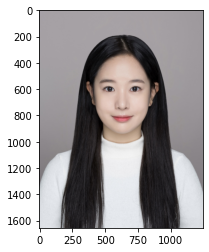

In [2]:
# 이미지 경로 설정
basic_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ID.png' # 기본 이미지
bright_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/bright.png' # 밝은 이미지
dark_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/dark.png' # 어두운 이미지
multi_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/multi.png' # 얼굴이 여러 개인 이미지
crop_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/crop.png' # 얼굴 일부가 잘린 이미지

# OpenCV로 이미지 불러오기
basic_img_bgr = cv2.imread(basic_image_path)
bright_img_bgr = cv2.imread(bright_image_path)
dark_img_bgr = cv2.imread(dark_image_path)
multi_img_bgr = cv2.imread(multi_image_path)
crop_img_bgr = cv2.imread(crop_image_path)

# OpenCV 기본값 BGR(Blue, Green, Red) -> RGB(Red, Green, Blue) 변경
basic_img_rgb = cv2.cvtColor(basic_img_bgr, cv2.COLOR_BGR2RGB)
bright_img_rgb = cv2.cvtColor(bright_img_bgr, cv2.COLOR_BGR2RGB)
dark_img_rgb = cv2.cvtColor(dark_img_bgr, cv2.COLOR_BGR2RGB)
multi_img_rgb = cv2.cvtColor(multi_img_bgr, cv2.COLOR_BGR2RGB)
crop_img_rgb = cv2.cvtColor(crop_img_bgr, cv2.COLOR_BGR2RGB)

# 미리보기
print("미리보기")
plt.imshow(basic_img_rgb)
plt.show()

##### dlib의 Face Detector을 이용하여  얼굴 Bounding Box 구하기

rectangles[[(399, 451) (861, 913)]]


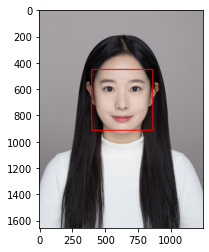

In [3]:
detector_hog = dlib.get_frontal_face_detector() # Face Detector (HOG) 선언

basic_dlib_rects = detector_hog(basic_img_rgb, 1) # 얼굴 bounding box 추출, 이미지 피라미드(크기)는 1 : 원본
print(basic_dlib_rects)

img_show = basic_img_rgb.copy() # 출력용 이미지

# 얼굴 bounding box 사각형 그리기 
for dlib_rect in basic_dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (255, 0, 0), 5, lineType = cv2.LINE_AA) 

# 미리보기
plt.imshow(img_show)
plt.show()

##### dlib 모델을 이용하여 얼굴 Landmark(이목구비) 구하기

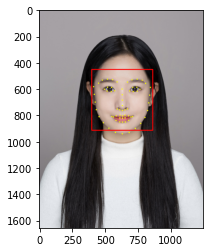

In [4]:
# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 구하기
list_landmarks = []

for dlib_rect in basic_dlib_rects:
    # 얼굴 landmark 좌표 저장
    points = landmark_predictor(basic_img_rgb, dlib_rect)
    list_points = list(map(lambda p : (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 얼굴 landmark 표시하기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (255, 255, 0), 5)

# 미리보기
plt.imshow(img_show)
plt.show()

##### 스티커 위치 및 크기 설정 
- 위치 고양이 코가 콧망울에 위치하도록 (x = x_nose, y = (y_코 + y_코끝) / 2) 
- 크기 (width_box x width_box)

In [5]:
# 스티커 위치 및 크기 지표 설정
for dlib_rect, landmark in zip(basic_dlib_rects, list_landmarks):
    x = landmark[30][0] # landmark[30] : 코
    y = (landmark[30][1] + landmark[33][1]) // 2 # landmark[33] : 코 끝
    w = dlib_rect.width()
    h = dlib_rect.width()

# 스티커 크기 적용
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png' # 스티커 불러오기
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 크기 적용

# 좌표 조정 (top-left)
refined_x = x - w // 2
refined_y = y - h // 2

# 스티커가 사진 밖으로 넘어갈 경우 자르기
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

##### 스티커 적용

In [6]:
sticker_area = img_show[refined_y : refined_y + img_sticker.shape[0],
                        refined_x : refined_x + img_sticker.shape[1]]

# cat-whiskers.png의 경우 sticker == 255(흰색) 배경이므로
# sticker == 255 : img show, sticker != 255 : img_sticker 적용
img_show[refined_y : refined_y + img_sticker.shape[0],
         refined_x : refined_x + img_sticker.shape[1]] = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)

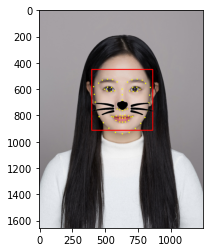

In [7]:
plt.imshow(img_show)
plt.show()

##### 스티커 투명도 조절

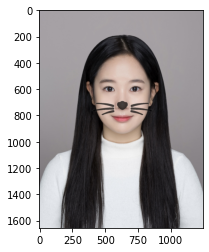

In [8]:
sticker_img = basic_img_rgb.copy() # 스티커를 붙일 이미지 생성

sticker_area = sticker_img[refined_y : refined_y + img_sticker.shape[0], \
                             refined_x : refined_x + img_sticker.shape[1]]

sticker_img[refined_y : refined_y + img_sticker.shape[0], \
              refined_x : refined_x + img_sticker.shape[1]] = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)

basic_img_rgb = cv2.addWeighted(basic_img_rgb, 0.3, sticker_img, 0.7, 0) # 원본 이미지 * 0.3 + 스티커 이미지 * 0.7

plt.imshow(basic_img_rgb)
plt.show()

### 다양한 사진에 적용

함수 사용 (위와 동일)

In [9]:
def put_sticker(img_rgb):
    img_show = img_rgb.copy()
    
    # 미리보기
    print("1. 이미지 보관")
    plt.imshow(img_show)
    plt.show()
    
    # bounding box
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_rgb, 1)
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        
        cv2.rectangle(img_show, (l, t), (r, b), (255, 0, 0), 5, lineType = cv2.LINE_AA)
    
    print("2. 얼굴 Bounding Box 설정")
    plt.imshow(img_show)
    plt.show()
    
    # landmark
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    list_landmarks = []
    
    for dlib_rect in basic_dlib_rects:
        points = landmark_predictor(basic_img_rgb, dlib_rect)
        list_points = list(map(lambda p : (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (255, 255, 0), 5)
            
    print("3. 얼굴 Landmark 탐색")
    plt.imshow(img_show)
    plt.show()
    
    # 스티커 위치 및 크기 설정
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))

    refined_x = x - w // 2
    refined_y = y - h // 2

    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
    
    # 스티커 적용 테스트
    sticker_area = img_show[refined_y : refined_y + img_sticker.shape[0],
                        refined_x : refined_x + img_sticker.shape[1]]

    img_show[refined_y : refined_y + img_sticker.shape[0],
             refined_x : refined_x + img_sticker.shape[1]] = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
    
    print("4. 스티커 적용 확인")
    plt.imshow(img_show)
    plt.show()
    
    # 결과
    sticker_img = img_rgb.copy()
    
    sticker_area = sticker_img[refined_y : refined_y + img_sticker.shape[0],
                                 refined_x : refined_x + img_sticker.shape[1]]
    sticker_img[refined_y : refined_y + img_sticker.shape[0],
                refined_x : refined_x + img_sticker.shape[1]] = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
    
    img_rgb = cv2.addWeighted(img_rgb, 0.3, sticker_img, 0.7, 0)
    
    print("5. 최종 결과물")
    plt.imshow(img_rgb)
    plt.show()


##### 밝은 이미지

1. 이미지 보관


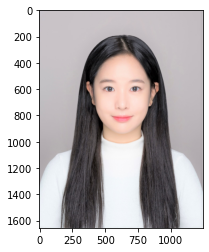

2. 얼굴 Bounding Box 설정


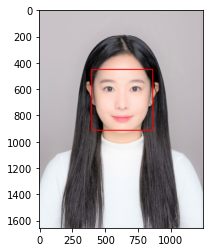

3. 얼굴 Landmark 탐색


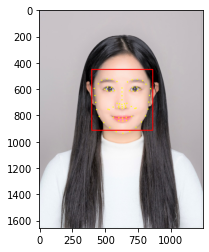

4. 스티커 적용 확인


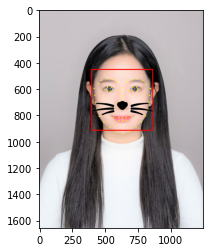

5. 최종 결과물


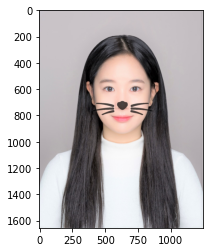

In [10]:
put_sticker(bright_img_rgb)

##### 어두운 이미지

1. 이미지 보관


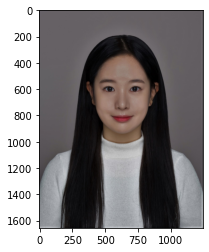

2. 얼굴 Bounding Box 설정


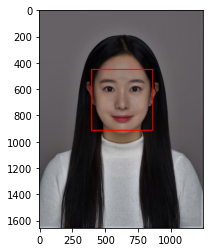

3. 얼굴 Landmark 탐색


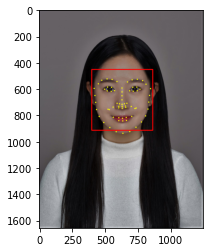

4. 스티커 적용 확인


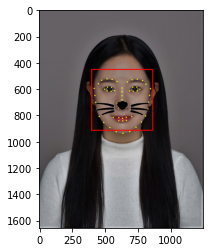

5. 최종 결과물


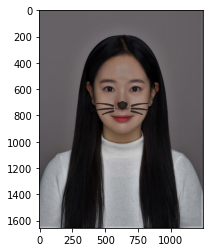

In [11]:
put_sticker(dark_img_rgb)

##### 얼굴이 여러 개인 이미지

1. 이미지 보관


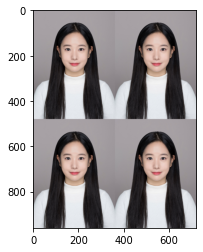

2. 얼굴 Bounding Box 설정


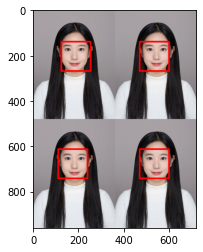

3. 얼굴 Landmark 탐색


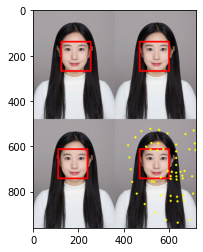

ValueError: operands could not be broadcast together with shapes (463,463,3) (447,320,3) (463,463,3) 

In [12]:
put_sticker(multi_img_rgb)

1. 이미지 보관


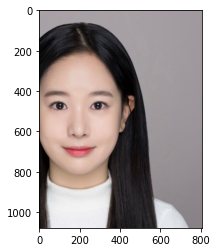

2. 얼굴 Bounding Box 설정


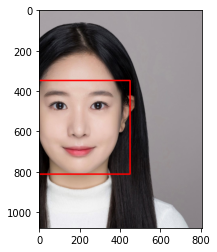

3. 얼굴 Landmark 탐색


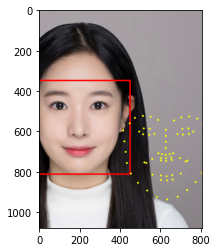

ValueError: operands could not be broadcast together with shapes (463,463,3) (463,408,3) (463,463,3) 

In [13]:
put_sticker(crop_img_rgb)

# 회고

## 프로젝트의 평가 및 한계점

- 밝은 이미지와 어두운 이미지 <br/>
밝은 이미지와 어두운 이미지의 경우 얼굴 분석이 원활했고, 스티커 부착이 비교적 자연스러웠다.<br/>

- 얼굴이 여러 개인 이미지<br/>
얼굴이 여러 개인 이미지의 경우 bounding box는 잘 그려졌지만, landmark 탐색 과정에서 오류가 있었다.<br/>
얼굴이 여러 개인 것과 별개로, 이미지의 크기가 작으면 분석력이 떨어지는 것으로 보인다.<br/>
또한 얼굴이 여러 개일 경우 모두 스티커가 붙지 않고 그 중 하나의 얼굴에만 스티커가 붙을 것으로 생각된다.<br/>
먼저 탐색이 완료되는 얼굴에 붙을 것으로 예상되는데, 일반적으로는 (0, 0)에서 분석을 시작하니 가장 왼쪽 상단에 얼굴에 붙을듯하다.<br/>
시간이 부족해 확인하지 못했다.<br/>

- 잘린 이미지<br/>
얼굴 전체가 다 보이지 않는 경우 bounding box는 잘 그려졌지만, landmark 탐색 과정에서 오류가 생긴다.<br/>
얼굴이 여러 개인 이미지와 잘린 이미지 모두 landmark가 쌩뚱맞은 곳에서 표시됐다.<br/>
짐작컨대 landmark 분석에 실패하더라도 어떠한 결과값을 내놓는 방식이지 않나 싶다.<br/>

## 학습 내용

- np.where(condition, True, False)<br/>
np.where() 함수는 조건문, 조건문이 참일 때 값, 조건문이 거짓일 때 값을 받아 사용한다.<br/>
다음 코드는 img의 y부터 y+스티커의 height까지 그리고 x부터 x+스티커의 width까지 부분을 대체하는 코드이다.<br/>
이때 스티커가 255(흰색)일 때, 기존 이미지(sticker_area에 미리 할당) 값을 넣고 스티커가 255가 아닐 때 실제 스티커 이미지 값을 넣겠다는 뜻이다.<br/>
<br/>
```
img[y : y + img_sticker.shape[0],
    x : x + img_sticker.shape[1]] = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
```
<br/>
아이콘 이미지에 따라서 배경이 흰색일 수도 검은색일 수도 있으니 주의할 필요가 있다.<br/>
추가로, 판다스에도 where 함수가 있다.<br/>
다음 블로그를 참고했다.<br/>
[Python - pd.where과 np.where의 차이, yg's blog, Yonggeun Shin, (2022.01.12)](https://yganalyst.github.io/data_handling/memo_3/)
<br/>

- jpg to png<br/>
이미지 데이터를 사용하는 분석 모델에서는 이미지 형식을 조절할 필요가 있다.<br/>
이 기능은 파이썬 및 Pillow(PIL) 라이브러리를 통해 가능한다.<br/>
<br/>
```
from PIL import Image
im = Image.open('filename.jpg').convert('RGB')
im.save('filename.png', 'png')
```
<br/>
[Python - PIL jpg png webp 변환 Image.convert(), 개발인생, bryan.on, (2022.01.12)](https://hello-bryan.tistory.com/295)
<br/>

- cv2.addWeighted()<br/>
cv2.add()는 두 이미지의 픽셀 값을 덧셈한다.<br/>
픽셀 값의 합이 255를 초과할 경우 255로 설정되기 때문에 이 연산을 사용할 경우 많은 부분이 255(흰색)으로 나타난다.<br/>
cv2.addWeighted()는 두 이미지의 가중치를 고려하여 덧셈한다.<br/>
스티커의 투명도를 조절한다고 했을 때, 대상 이미지와 스티커 이미지를 어떻게든 덧셈할 필요가 있다.<br/>
이 경우 addWeighted를 그냥 사용할 경우 스티커 이미지의 명료도만큼 대상 이미지의 명료도가 떨어진다.<br/>
예를 들어 대상 이미지의 가중치를 0.9로, 스티커 이미지의 가중치를 0.1로 설정한다고 하면 투명도를 조절할 필요가 전혀 없는 대상 이미지의 투명도가 0.1 커지는 것이다.<br/>
물론 스티커 이미지가 너무 투명한 것도 문제다.<br/>
따라서 addWeighted 할 두 이미지는 대상 이미지와 스티커 이미지가 아니라 스티커를 붙인 대상 이미지와 기존 대상 이미지이다.<br/>
<br/>
```
    sticker_img = img_rgb.copy()
    
    sticker_area = sticker_img[refined_y : refined_y + img_sticker.shape[0],
                                 refined_x : refined_x + img_sticker.shape[1]]
    sticker_img[refined_y : refined_y + img_sticker.shape[0],
                refined_x : refined_x + img_sticker.shape[1]] = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
    
    img_rgb = cv2.addWeighted(img_rgb, 0.3, sticker_img, 0.7, 0)
```
<br/>
[파이썬 OpenCV - 영상의 산술 연산 cv2.add, cv2.addWeighted, 딥러닝 공부방, AI 꿈나무, (2022.01.12)](https://deep-learning-study.tistory.com/115)
<br/>

- HOG & SVM<br/>
HOG(Histogram of Oriented Gradients)는 이미지에서 "색상의 변화량"을 나타낸 것이다.<br/>
SVM(Support Vector Machines)은 데이터가 다차원 벡터로 있을 때 거리가 가장 먼 벡터를 선택하여 분리하는 방법으로 최대 마진 분류기라고도 한다.<br/>
이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 추적하므로 같이 쓰이는 경우가 많다.<br/>
<br/>
[Object Tracking - SVM을 이용한 HOG 기반 객체 추적, Enough is not enough, 꾸준희, (2022.01.12)](https://eehoeskrap.tistory.com/122#recentComments)
<br/>